In [1]:
import utilities as ut
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler
import matplotlib as mpl
import seaborn as sns
import pyPLS
import warnings
warnings.simplefilter(action='ignore')


In [2]:
feat_path = "./data/2020_11_04_CPJUMP1_normalized_feature_select_negcon_batch_Standard.parquet.gz"
cell_line = 'A549'
comp_time = 48
pn_cond_query = f"Metadata_experiment_type == 'Compound' \
            & Metadata_cell_line == '{cell_line}' \
            & Metadata_timepoint == {comp_time} \
            & Metadata_experiment_condition == 'Standard' \
            & (Metadata_control_type == 'negcon' \
            | Metadata_control_type == 'poscon_orf') "
# Compound only positive and negative controls DataFrame
comp_opn_df = pd.read_parquet(feat_path)
comp_opn_df = comp_opn_df.query(pn_cond_query)

In [3]:
comp_opn_df = pd.concat([ut.get_metadata(comp_opn_df), ut.get_featuredata(comp_opn_df).applymap(ut.log_transform)], axis=1)
max_components=10
opn_comp_eq_results, opn_ess_df, _ = ut.calc_eq_score_df_with_cv_optimized(fit_df=comp_opn_df, pred_df=comp_opn_df, max_ncp=max_components)

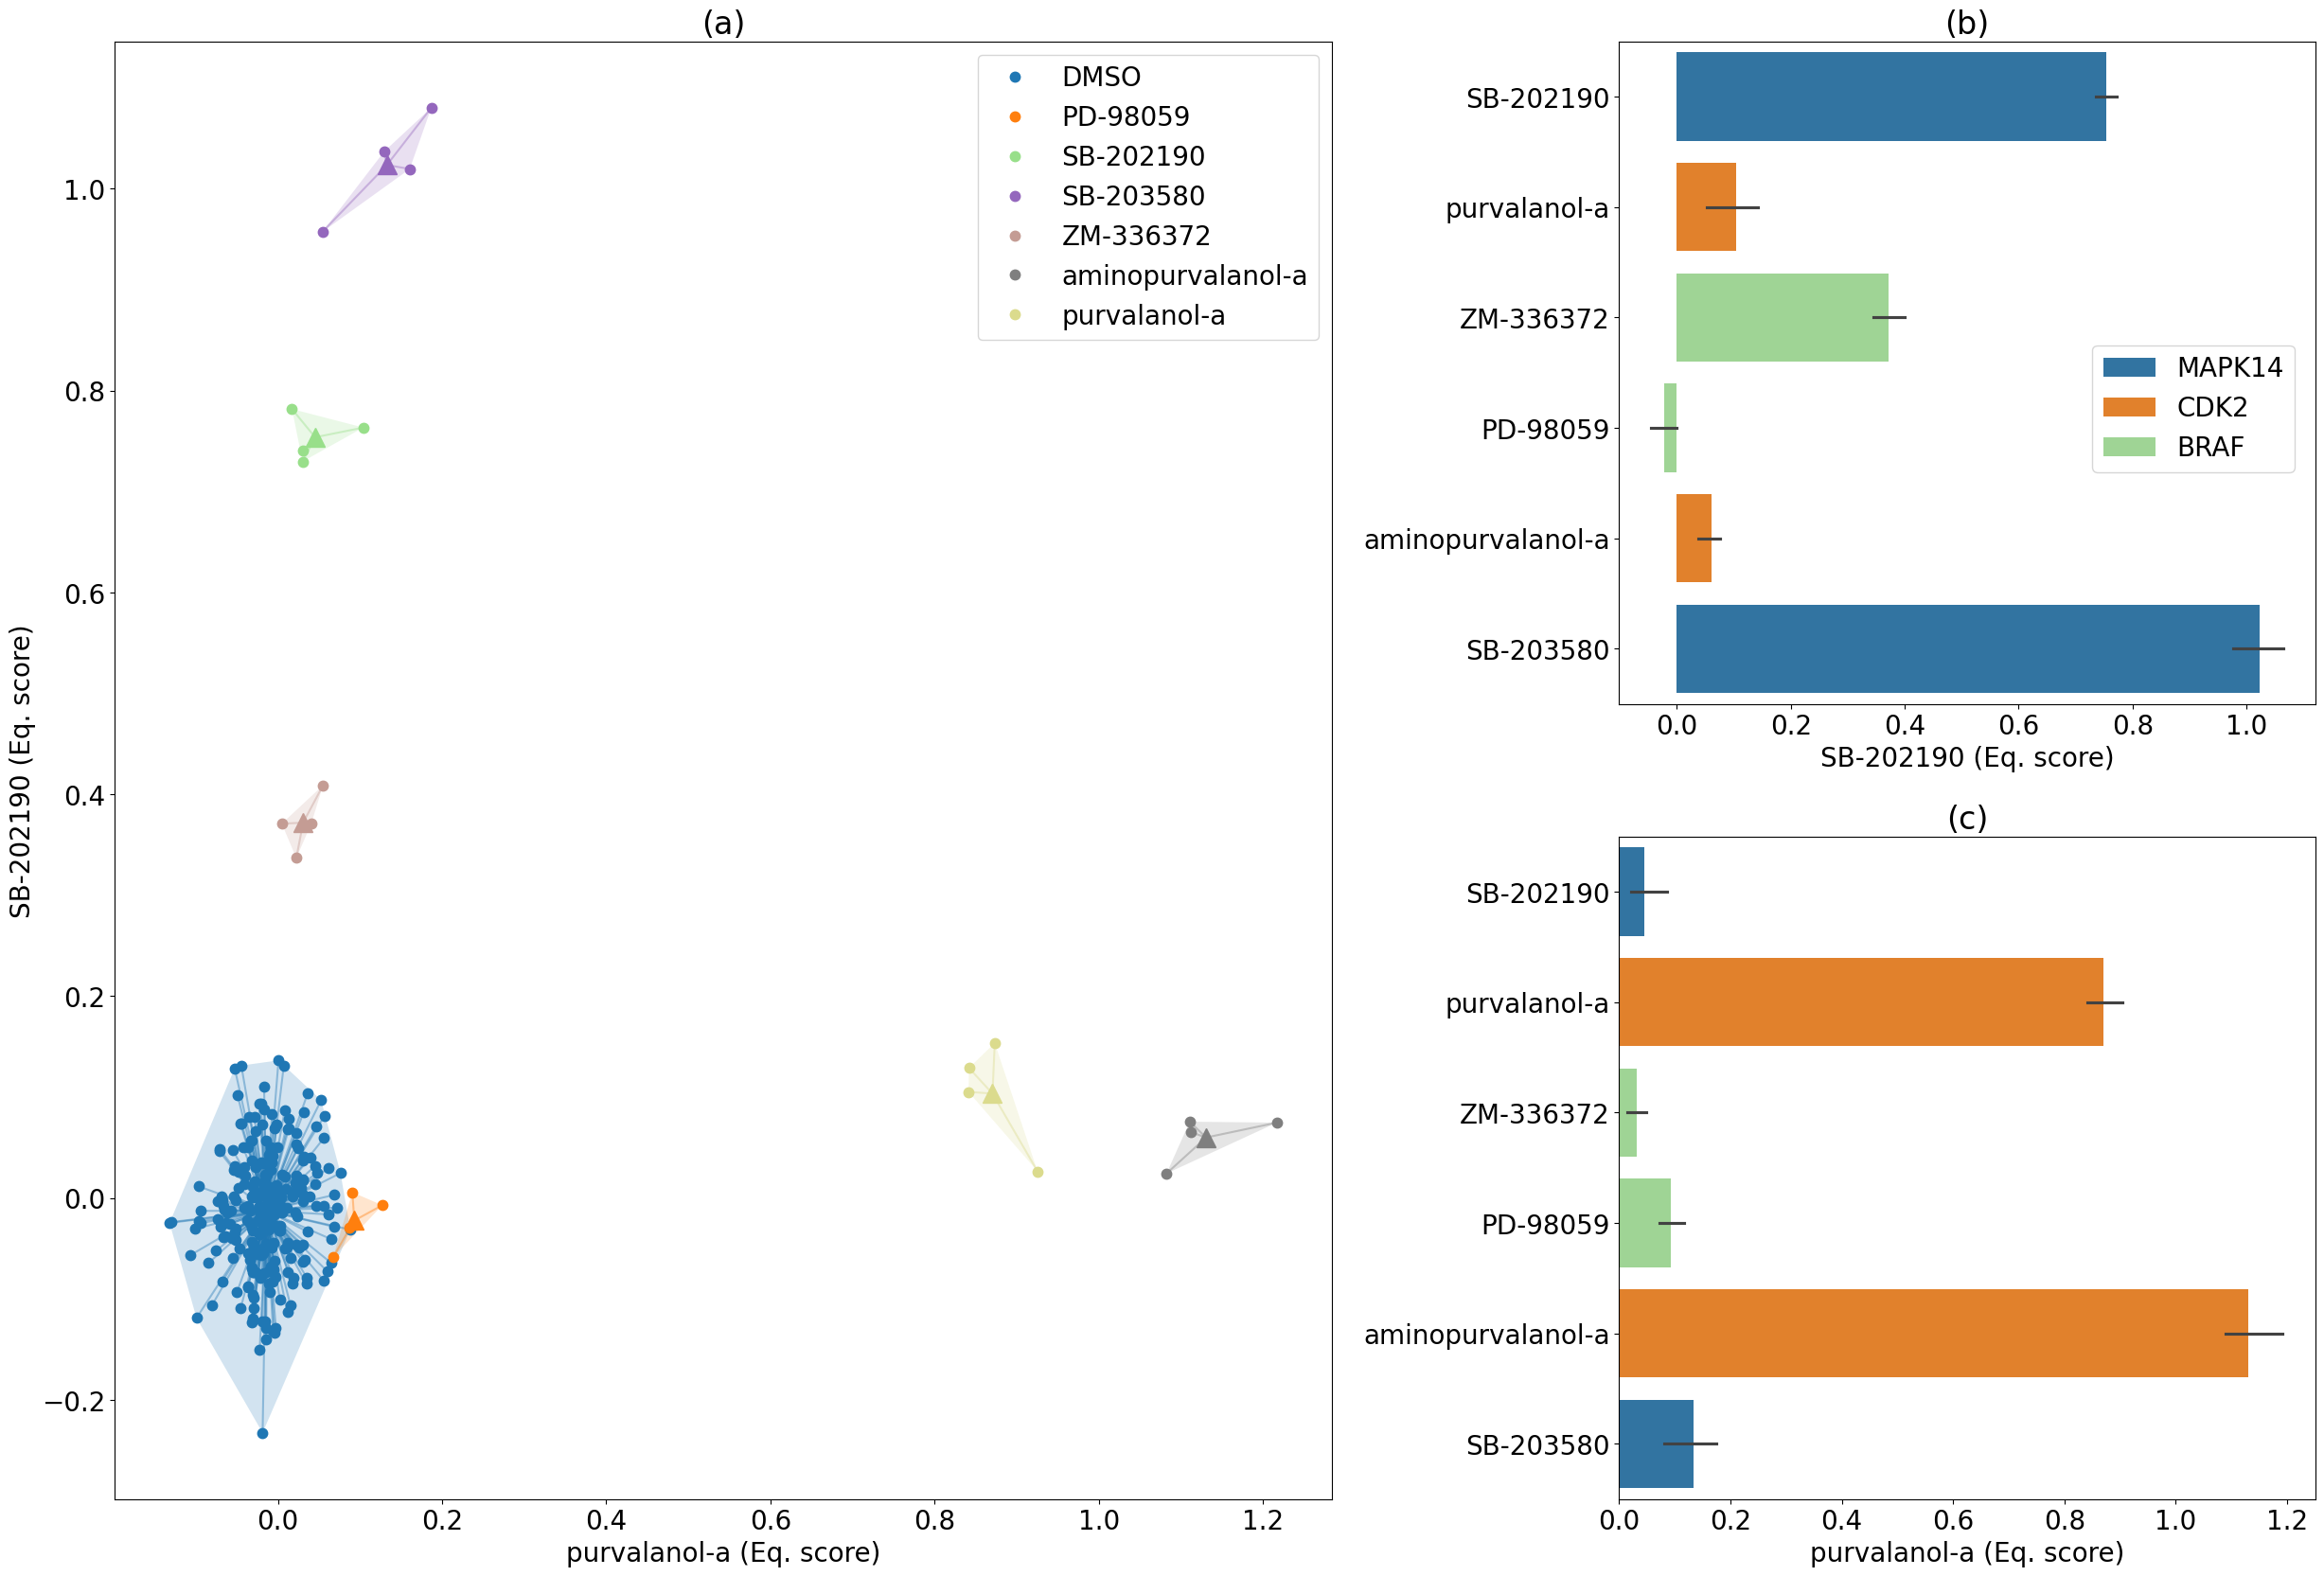

In [5]:
### Generate Figure 4
cp = ut.ClusterPlot()
gs_kw = dict(width_ratios=[1.75, 1], height_ratios=[1, 1], wspace=0.3)
fig, axd = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              figsize=(30, 20), gridspec_kw=gs_kw)

for k in ['left', 'upper right', 'lower right']:
    ax = axd[k]
    if k == 'left':
        cp.plot_fig_with_clusters(opn_comp_eq_results, 'Metadata_pert_iname', x_axis='purvalanol-a_eq', y_axis='SB-202190_eq', ax=ax)
        ax.set_ylabel('SB-202190 (Eq. score)')
        ax.set_xlabel('purvalanol-a (Eq. score)')
        ax.legend()
        ax.set_title('(a)')
    elif k == 'upper right':
        sns.barplot(x="SB-202190_eq", y="Metadata_pert_iname", data=opn_comp_eq_results[opn_comp_eq_results['Metadata_pert_iname'] != 'DMSO'], dodge=False, ax=ax, hue='Metadata_target')
        ax.set_ylabel('')
        ax.set_title('(b)')
        ax.set_xlabel('SB-202190 (Eq. score)')
        ax.legend(loc=(0.68,0.35))
    elif k == 'lower right':
        sns.barplot(x="purvalanol-a_eq", y="Metadata_pert_iname", data=opn_comp_eq_results[opn_comp_eq_results['Metadata_pert_iname'] != 'DMSO'], dodge=False, ax=ax, hue='Metadata_target')
        ax.set_ylabel('')
        ax.set_title('(c)')
        ax.set_xlabel('purvalanol-a (Eq. score)')
        ax.legend_.remove()
plt.savefig("./figures/eq_bar_scatter.png", bbox_inches='tight')
plt.show()


In [9]:
op_comp_eq_results = opn_comp_eq_results[opn_comp_eq_results['Metadata_pert_iname'] != 'DMSO'].copy()
op_comp_sse_results = opn_ess_df[opn_ess_df['Metadata_pert_iname'] != 'DMSO'].copy()
div_df = pd.concat([ut.get_metadata(op_comp_eq_results), ut.get_featuredata(op_comp_eq_results) /(ut.get_featuredata(op_comp_sse_results).values)], axis=1)

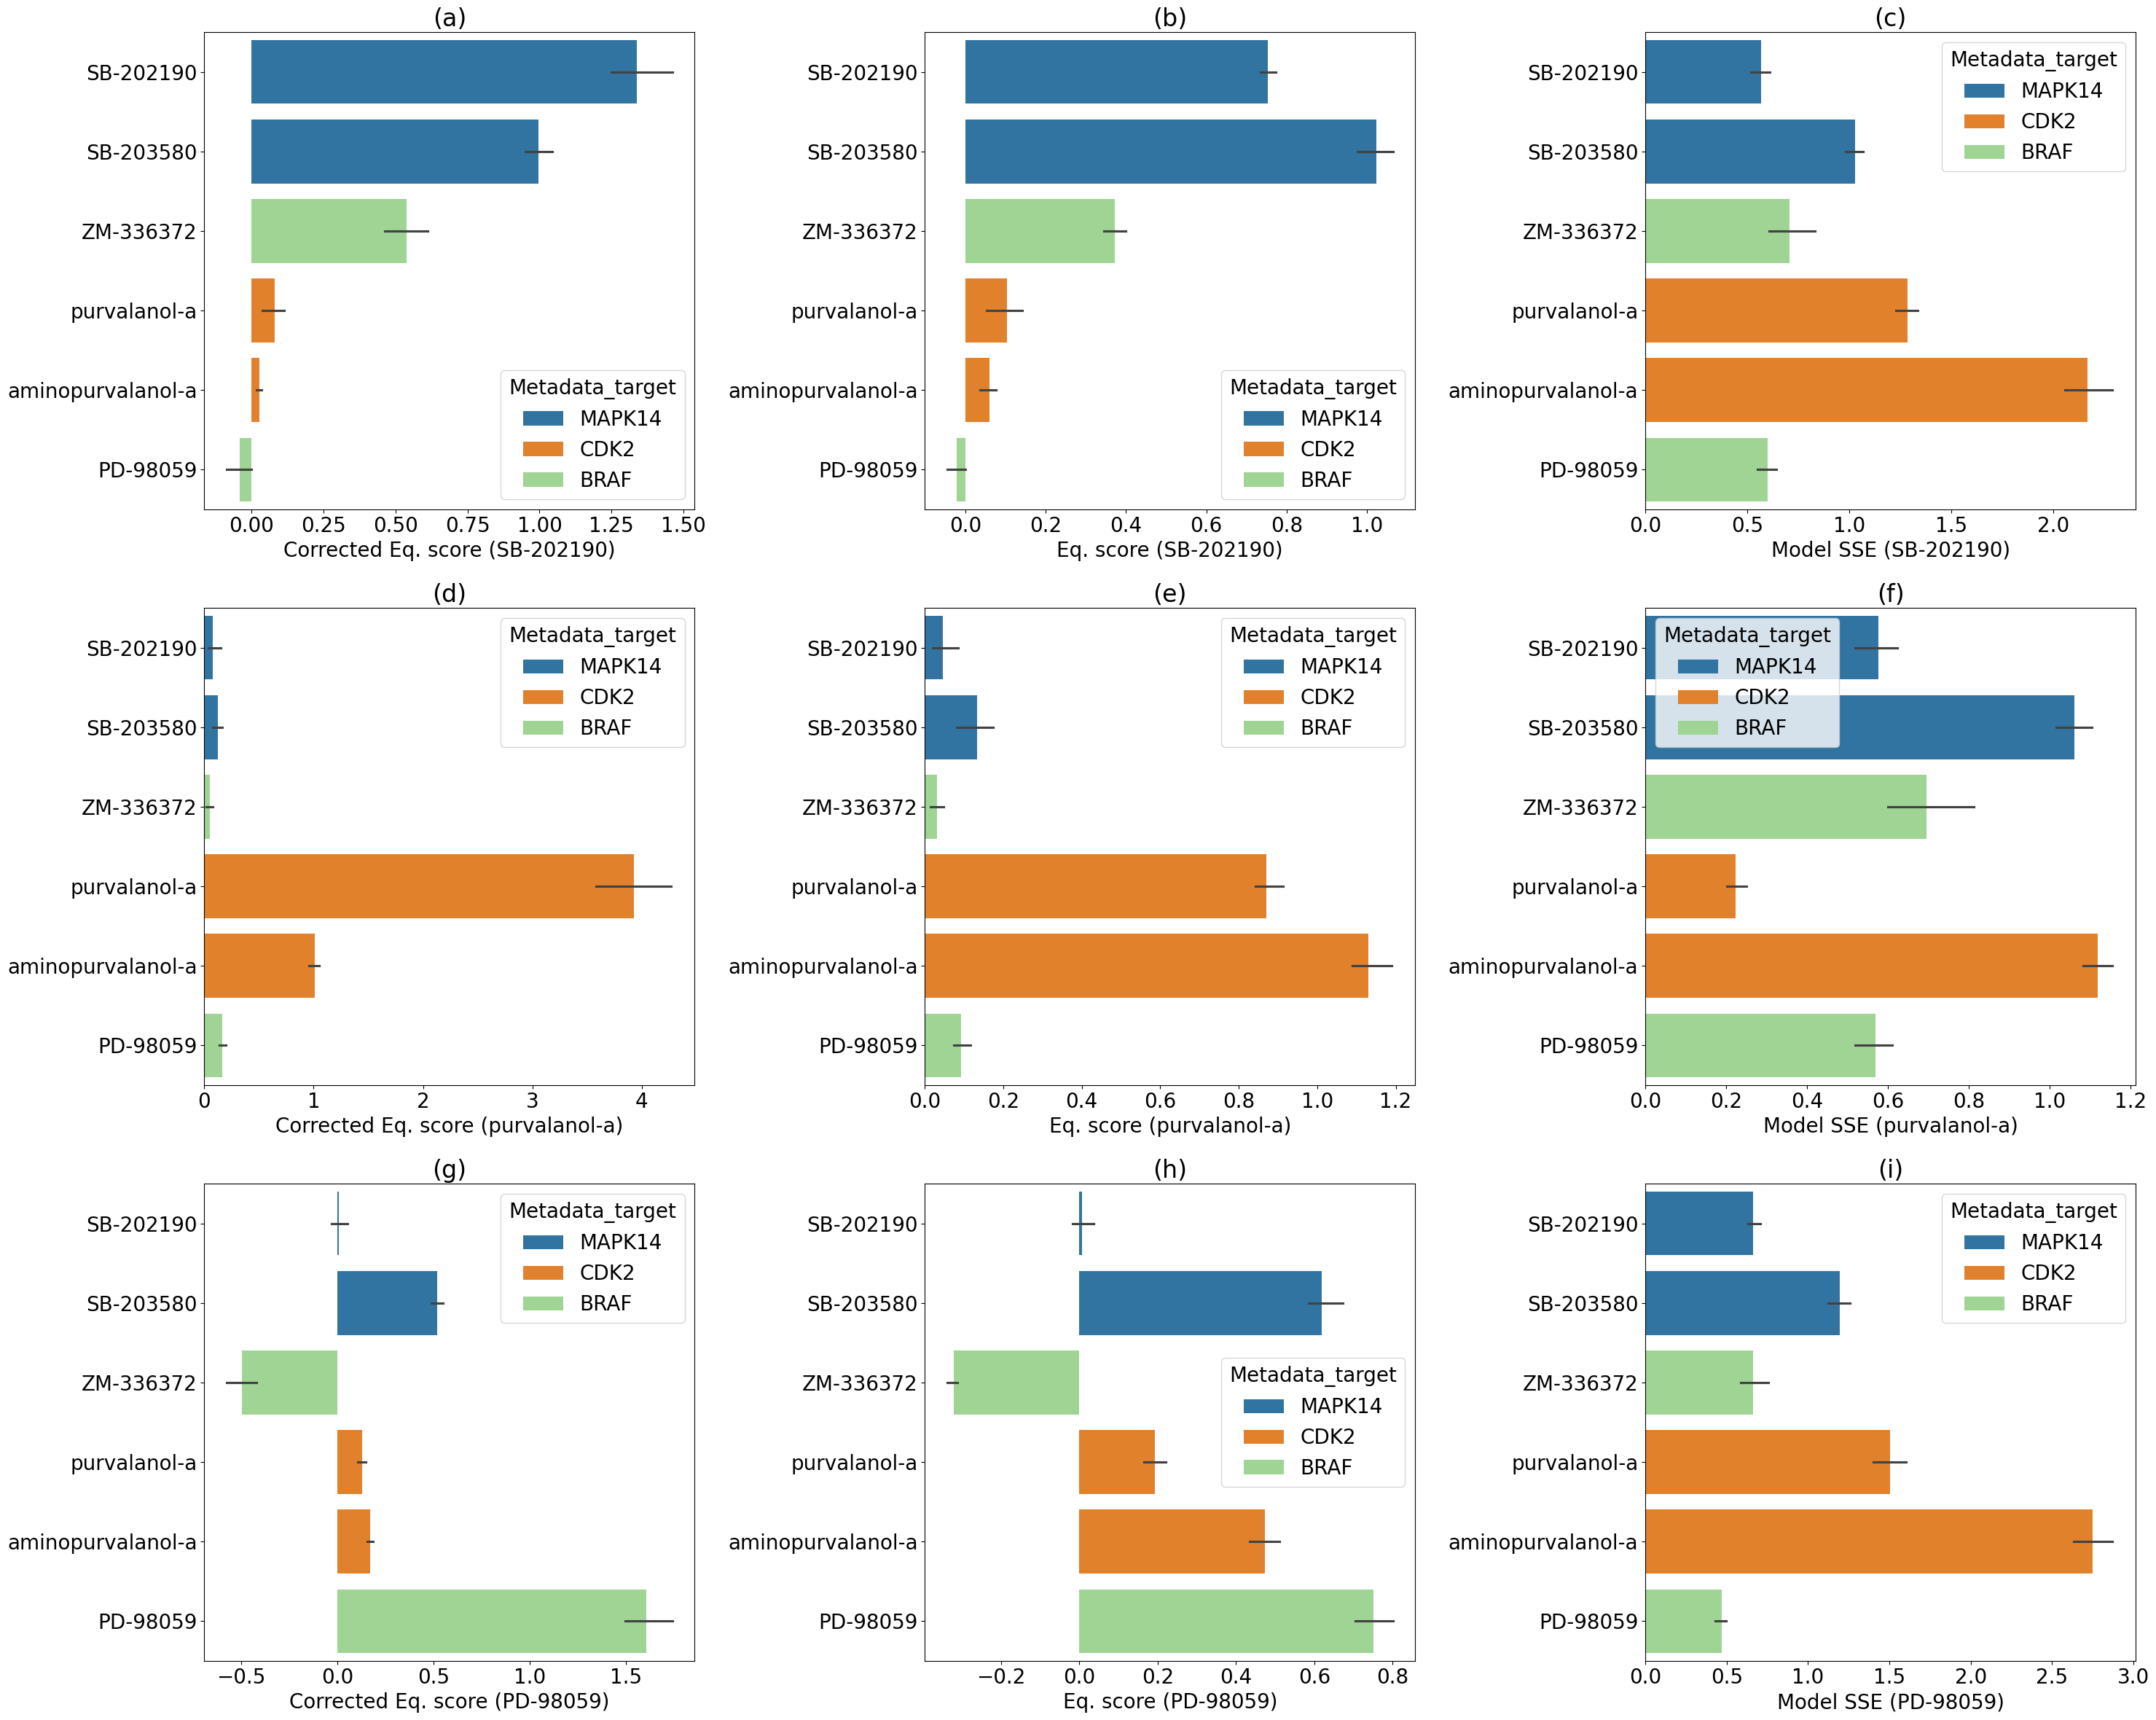

In [10]:
#### Generate Figure 5
rcParams['figure.figsize'] = 30, 24
rcParams['font.size'] = 20
cm = plt.get_cmap('tab20')
n_colors = len(opn_comp_eq_results['Metadata_pert_iname'].unique())
mpl.rcParams['axes.prop_cycle'] = cycler(color=[cm(1.*i/n_colors) for i in range(n_colors)])
n_compare=10
op_comp_eq_results = opn_comp_eq_results[opn_comp_eq_results['Metadata_pert_iname'] != 'DMSO'].copy()
abc = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
perts = ['SB-202190', 'purvalanol-a', 'PD-98059']
i = 0
j = 0
k = 0
fig, ax = plt.subplots(3,3)
for pert in perts:
    if pert == 'DMSO':
        pass        
    else:
        i = 0
        ind = []
        ind.append(pert)
        # 1. Group by the 'Metadata_pert_iname' column
        grouped = op_comp_eq_results.groupby('Metadata_pert_iname')

        # 2. Compute the median for each group
        numeric_cols = op_comp_eq_results.select_dtypes(include=[np.number]).columns

        medians = grouped[numeric_cols].aggregate(np.median)
        
        # 2. Group and select a representative value for non-numeric columns
        non_numeric_cols = op_comp_eq_results.select_dtypes(exclude=[np.number]).columns
        representative_non_numeric = grouped[non_numeric_cols].first()

        # 3. Concatenate the results
        medians = pd.concat([medians, representative_non_numeric], axis=1)
        
        # 3. Retrieve the `n_compare` largest values based on the column given by `f"{pert}_eq"`
        largest_values = medians.nlargest(n_compare, f"{pert}_eq")

        # 4. Extract the index of those rows and convert it to a list
        indices_list = largest_values.index.tolist()

        # 5. Extend the list `ind` with the result
        ind.extend(indices_list)

        cond = (" | ".join(["(Metadata_pert_iname == '{0}')".format(i) for i in ind]))
        result = div_df.query(cond).groupby('Metadata_pert_iname')[f"{pert}_eq"].aggregate(np.median).reset_index().sort_values(f"{pert}_eq", ascending=False)        
        if j == 0:
                bar = sns.barplot(x=f"{pert}_eq", y='Metadata_pert_iname', data=div_df.query(cond), ax=ax[j, i], 
                     order=result['Metadata_pert_iname'], hue='Metadata_target', dodge=False)
                ordered_result = result.copy()
        else:
                bar = sns.barplot(x=f"{pert}_eq", y='Metadata_pert_iname', data=div_df.query(cond), ax=ax[j, i], 
                     order=ordered_result['Metadata_pert_iname'], hue='Metadata_target', dodge=False)
       
       
        ax[j, i].set_ylabel('')
        ax[j, i].set_xlabel(f"Corrected Eq. score ({pert})")
        ax[j, i].title.set_text(f"({abc[k]})")
        k += 1
        i += 1
        
        bar = sns.barplot(x=f"{pert}_eq", y='Metadata_pert_iname', data=op_comp_eq_results.query(cond), ax=ax[j, i], 
                     order=ordered_result['Metadata_pert_iname'], hue='Metadata_target', dodge=False)
      
        ax[j, i].set_xlabel(f"Eq. score ({pert})")
        ax[j, i].set_ylabel('')
        ax[j, i].title.set_text(f"({abc[k]})")
        k += 1
        i += 1
        bar = sns.barplot(x=f"{pert}_SSE", y='Metadata_pert_iname', data=opn_ess_df.query(cond), ax=ax[j, i], 
                    order=ordered_result['Metadata_pert_iname'], hue='Metadata_target', dodge=False)
        ax[j, i].set_xlabel(f"Model SSE ({pert})")
        ax[j, i].set_ylabel('')
        ax[j, i].title.set_text(f"({abc[k]})")
        k += 1
        fig.tight_layout()
        j += 1
plt.savefig("./figures/eq_bar_plot.png", bbox_inches='tight')
plt.show()

Summary of input table
----------------------
Observations: 280
Variables: 6
Missing values: 0 (0.0%)

Summary of PCA:
---------------
Number of components: 3
Total Variance explained: 97.0%
Variance explained by component:
    - Component 1 : 49.0%
    - Component 2 : 32.800000000000004%
    - Component 3 : 15.2%


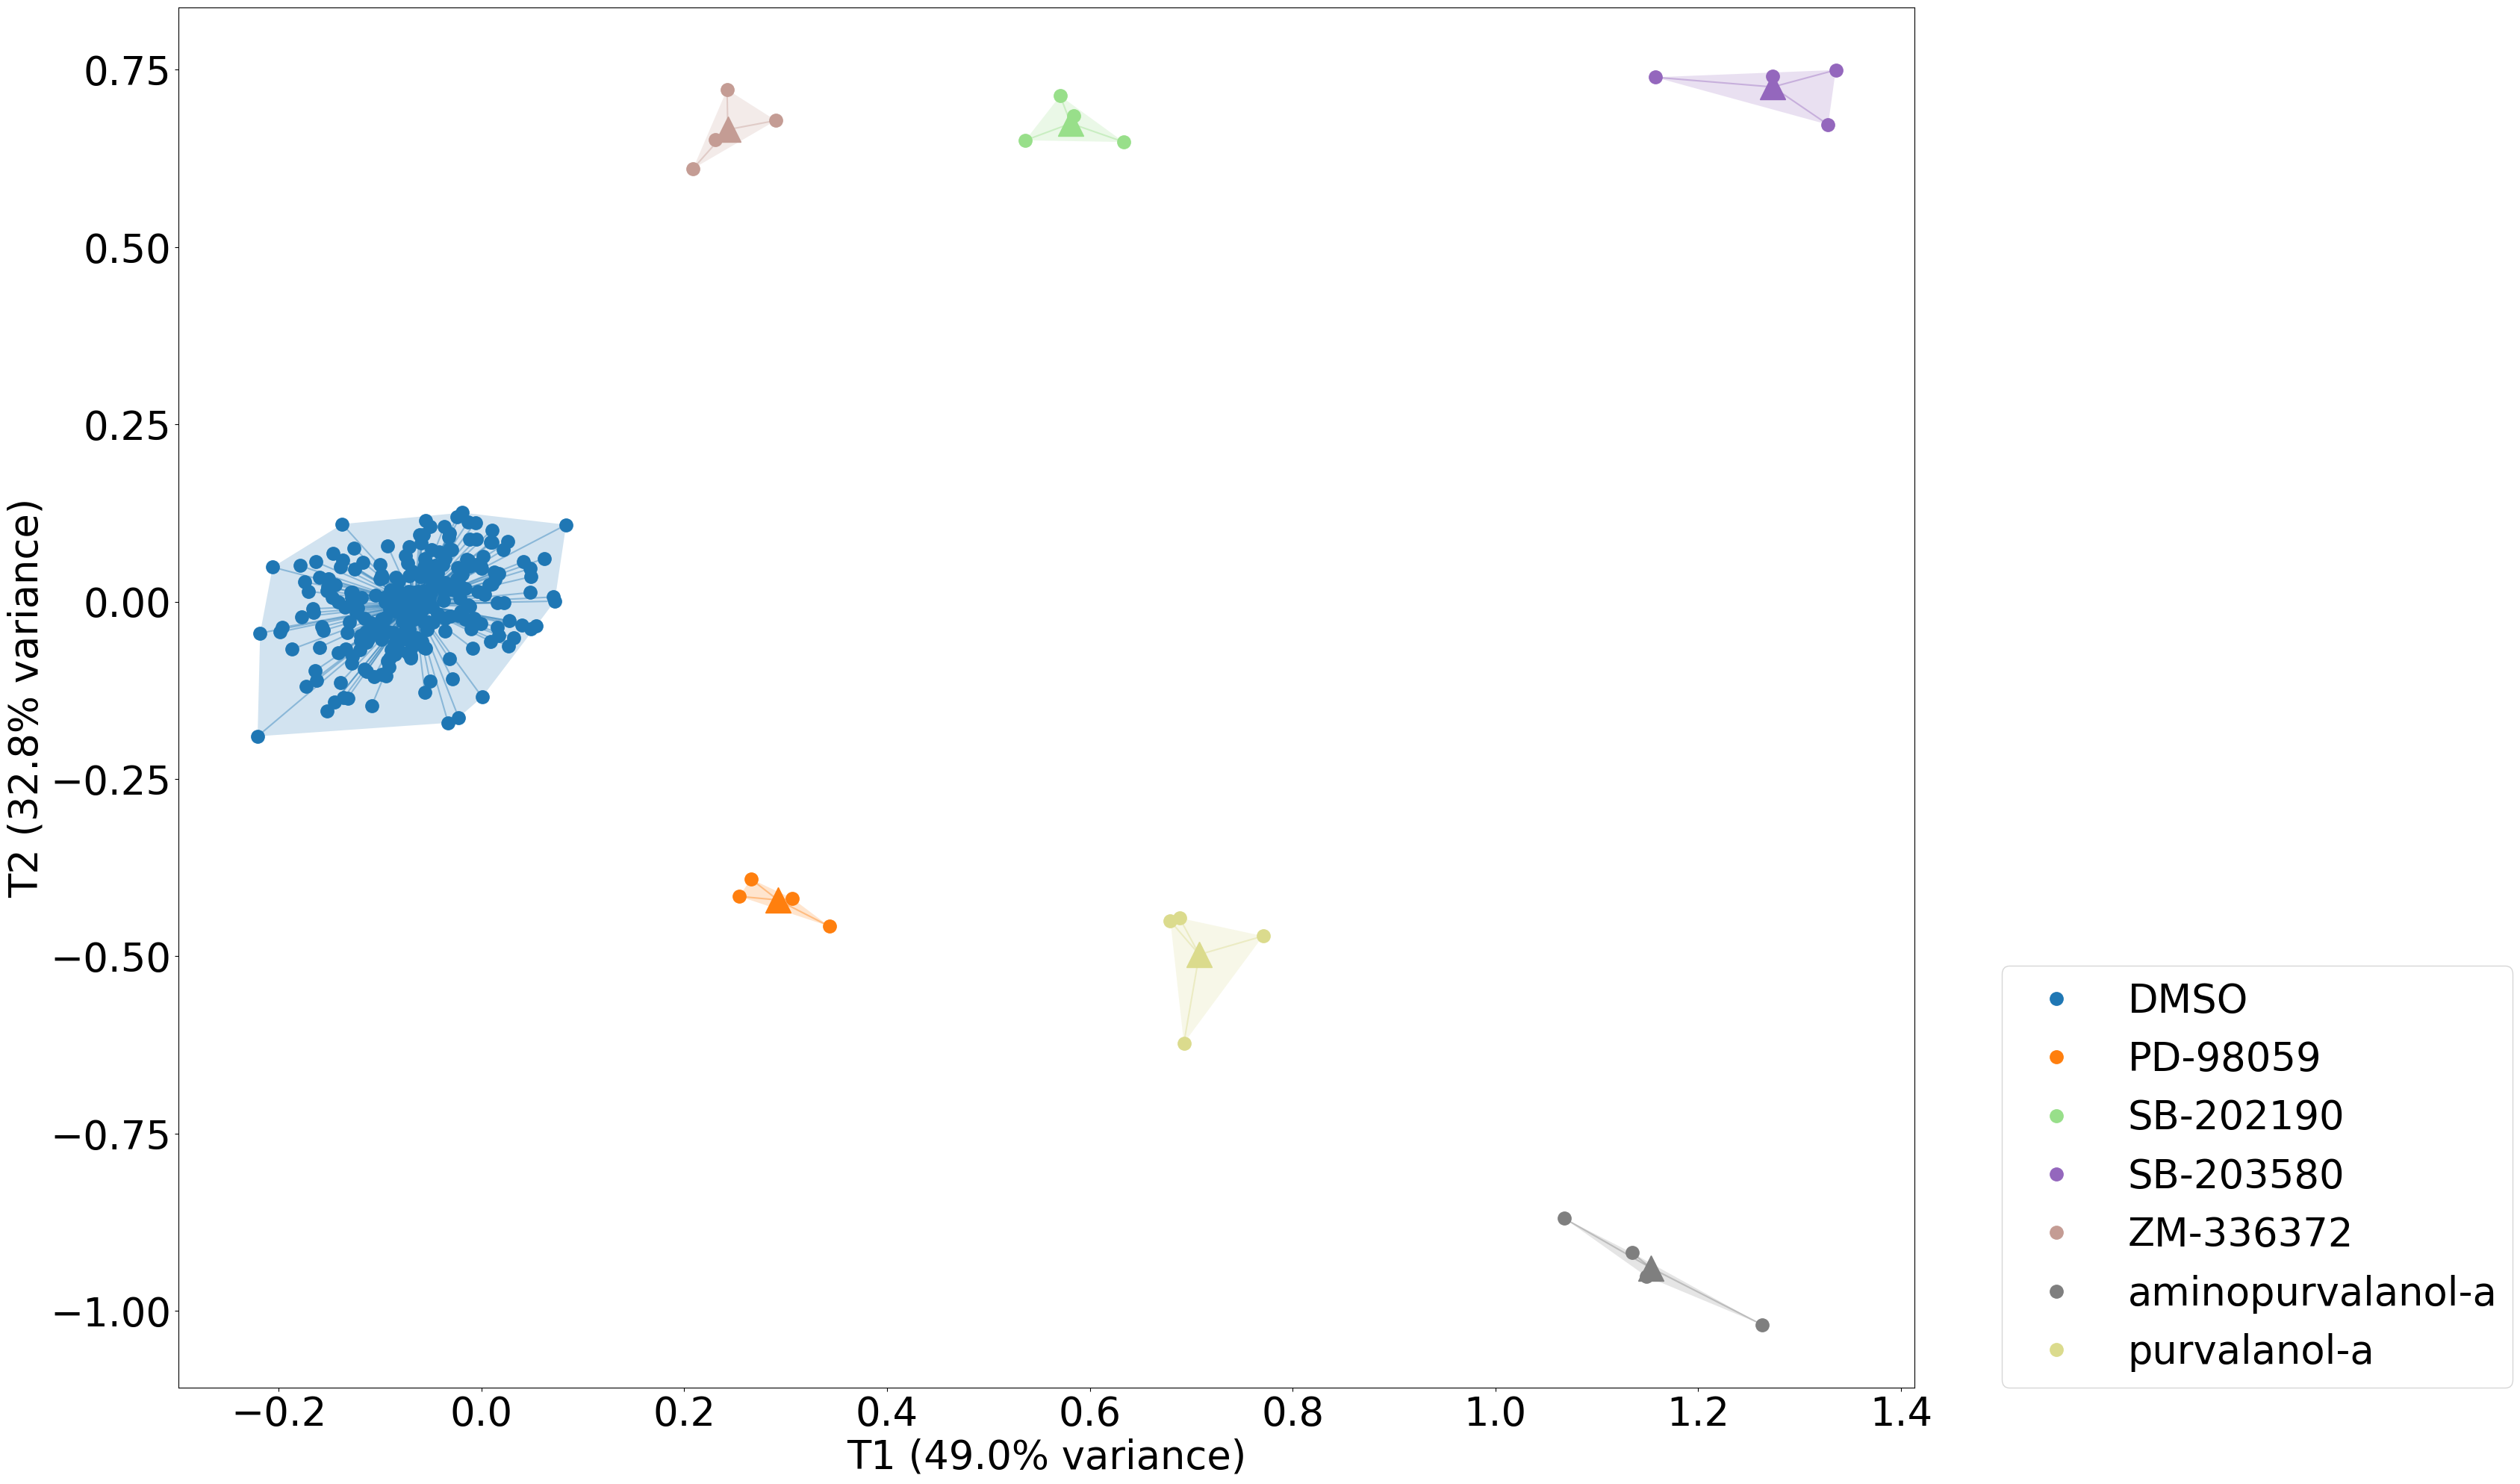

In [8]:
#### Generate Figure 6
rcParams['figure.figsize'] = 30, 24
rcParams['font.size'] = 38
cp = ut.ClusterPlot()
pn_eq_results = opn_comp_eq_results.copy()
scaling = 0
pypls_pca = pyPLS.pca(ut.get_featuredata(pn_eq_results).values.astype(float), a=3, scaling=scaling)
pypls_pca.summary()

pn_eq_results['T1'] = pypls_pca.T[:, 0]
pn_eq_results['T2'] = pypls_pca.T[:, 1]
pn_eq_results['T3'] = pypls_pca.T[:, 2]
cp.plot_fig_with_clusters(pn_eq_results, metadata_grouping='Metadata_pert_iname', x_axis=f'T1', y_axis=f'T2', markersize=25, figure_size=(25, 20))

ax = plt.gca()
t_var = np.round(pypls_pca.R2X*100,1)
ax.set_xlabel(f'T1 ({t_var[0]}% variance)')
ax.set_ylabel(f'T2 ({t_var[1]}% variance)')
plt.savefig("./figures/pca_eq_comp_features.png", bbox_inches='tight')
plt.show()